In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from climtools import climtools_lib as ctl
import xarray as xr
import matplotlib.cbook as cbook
from scipy import stats
import pickle

No DISPLAY variable set. Switching to agg backend


In [2]:
#DIRECTORY
cart_out = '/home/fabiano/Research/lavori/TunECS/calcfb/'
ctl.mkdir(cart_out)

cart_in = '/nas/archive_CMIP6/CMIP6/model-output/EC-Earth-Consortium/EC-Earth3/'
filin_pi = cart_in + 'piControl/atmos/Amon/r1i1p1f1/{}/*nc'
filin_4c = cart_in + 'abrupt-4xCO2/atmos/Amon/r8i1p1f1_r25/{}/*nc'
filin_4c1 = cart_in + 'abrupt-4xCO2/atmos/Amon/r8i1p1f1/{}/*nc'

In [3]:
def read_kernels_Huang17(cart_kernels):
    """
    Reads broad-band kernels (Y. Huang, 2017)
    """

    finam = 'RRTMG_{}_toa_{}_highR.nc'

    vnams = ['t', 'ts', 'wv_lw', 'wv_sw', 'alb']
    tips = ['clr', 'cld']

    allkers = dict()
    for tip in tips:
        for vna in vnams:
            ker = xr.load_dataset(cart_k + finam.format(vna, tip))

            allkers[(tip, vna)] = ker.assign_coords(month = np.arange(1, 13))

    vlevs = xr.load_dataset(cart_k + 'dp.nc')

    return allkers, vlevs

In [7]:
#Kernel
cart_k = '/data-hobbes/fabiano/radiative_kernels/Huang/toa/'

finam = 'RRTMG_{}_toa_{}_highR.nc'

vnams = ['t', 'ts', 'wv_lw', 'wv_sw', 'alb']
tips = ['clr', 'cld']

allkers = dict()

for tip in tips:
    for vna in vnams:
        ker = xr.load_dataset(cart_k + finam.format(vna, tip))

        allkers[(tip, vna)] = ker.assign_coords(month = np.arange(1, 13))

vlevs = xr.load_dataset(cart_k + 'dp.nc')

k = allkers[('cld', 't')].lwkernel

In [4]:
cart_k = '/data-hobbes/fabiano/radiative_kernels/Huang/toa/'
allkers, vlevs = read_kernels_Huang17(cart_k)

In [29]:
allvars = 'rlutcs rsutcs clt hus rlut rsds rsus rsut ta tas ts'.split()

pimean = dict()
for vnam in allvars:
     print(vnam)
     pimean[vnam] = pickle.load(open(cart_out + 'pimean/pimean_' + vnam + '.p', 'rb'))

piclim = dict()
for vnam in allvars + ['alb']:#['ts', 'ta', 'hus', 'alb']:
     print(vnam)
     try:
          piclim[vnam] = pickle.load(open(cart_out + 'pimean/piclim_' + vnam + '.p', 'rb'))
     except:
          print(f"piclim for var {vnam} not found!")


rlutcs
rsutcs
clt
hus
rlut
rsds
rsus
rsut
ta
tas
ts
rlutcs
rsutcs
clt
piclim for var clt not found!
hus
rlut
rsds
rsus
rsut
piclim for var rsut not found!
ta
tas
piclim for var tas not found!
ts
alb


In [84]:
# # leggi pi e calcola pi mean
# allvars = 'rlutcs rsutcs clt hus rlut rsds rsus rsut ta tas ts'.split()

# pimean = dict()
# piclim = dict()
for vnam in 'rlutcs rsutcs rlut rsds rsus rsut'.split():#allvars:
    print(vnam)
    filist = glob.glob(filin_pi.format(vnam))
    filist.sort()

    var = xr.open_mfdataset(filist, use_cftime=True)

    var_mean = var.mean('time')
    var_mean = ctl.regrid_dataset(var_mean, k.lat, k.lon)
    pimean[vnam] = var_mean[vnam].compute()
    pickle.dump(pimean[vnam], open(cart_out + 'pimean/pimean_' + vnam + '.p', 'wb'))

    var_clim = var.groupby('time.month').mean()
    var_clim = ctl.regrid_dataset(var_clim, k.lat, k.lon)

    piclim[vnam] = var_clim[vnam].compute()
    pickle.dump(piclim[vnam], open(cart_out + 'pimean/piclim_' + vnam + '.p', 'wb'))

# # poi calcolo albedo
# pimean[('alb')] = pimean[('rsus')]/pimean[('rsds')]
# pickle.dump(pimean['alb'], open(cart_out + 'pimean/pimean_alb.p', 'wb'))
# piclim[('alb')] = piclim[('rsus')]/piclim[('rsds')]
# pickle.dump(piclim['alb'], open(cart_out + 'pimean/piclim_alb.p', 'wb'))

rlutcs
Regridding...
Regridding completed in 0:00:01.547281
Regridding...
Regridding completed in 0:00:00.987405
rsutcs
Regridding...
Regridding completed in 0:00:00.968427
Regridding...
Regridding completed in 0:00:00.940926
rlut
Regridding...
Regridding completed in 0:00:00.947854
Regridding...
Regridding completed in 0:00:00.954898
rsds
Regridding...
Regridding completed in 0:00:00.964441
Regridding...
Regridding completed in 0:00:00.967215
rsus
Regridding...
Regridding completed in 0:00:00.952334
Regridding...
Regridding completed in 0:00:00.967252
rsut
Regridding...
Regridding completed in 0:00:00.951757
Regridding...
Regridding completed in 0:00:00.981622


KeyboardInterrupt: 

In [31]:
num_year = 150

In [6]:
%matplotlib inline

## Calculating stratospheric mask (D. Rotoli)

In [7]:
##calcolare tropopausa (Reichler 2003) 
#ho usato solo def di gradiente in funzione di pressione

filist = glob.glob(filin_4c.format('ta'))
filist.sort()
temp = xr.open_mfdataset(filist[:num_year], chunks = {'time': 60})

A=(temp.plev/temp['ta'])*(9.81/1005)
laps1=(temp['ta'].diff(dim='plev'))*A  #derivata sulla verticale = laspe-rate
laps1=laps1.where(laps1<=-2)
mask = laps1/laps1

/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [22]:
mask

<xarray.DataArray (time: 120, plev: 18, lat: 73, lon: 144)>
dask.array<truediv, shape=(120, 18, 73, 144), dtype=float64, chunksize=(12, 18, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * plev     (plev) float64 9.25e+04 8.5e+04 7e+04 6e+04 ... 1e+03 500.0 100.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1859-12-16T12:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0

In [28]:
mfin = mask.sel(time = slice('01-01-1990', '12-31-1999')).mean('time').compute()
mini = mask.sel(time = slice('01-01-1850', '01-01-1860')).mean('time').compute()
mdiff = mfin.fillna(0.)-mini.fillna(0.)
ctl.plot_multimap_contour([mdiff[i] for i in range(len(mfin.plev))], cbar_range = (0, 1), subtitles = [f'{int(lev.values/100)} hPa' for lev in mfin.plev])

# there are small differences in stratopause level between beginning and end of simulation

In [ ]:
mm

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point

Adding cyclic point



/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


[<Figure size 1080x864 with 19 Axes>]

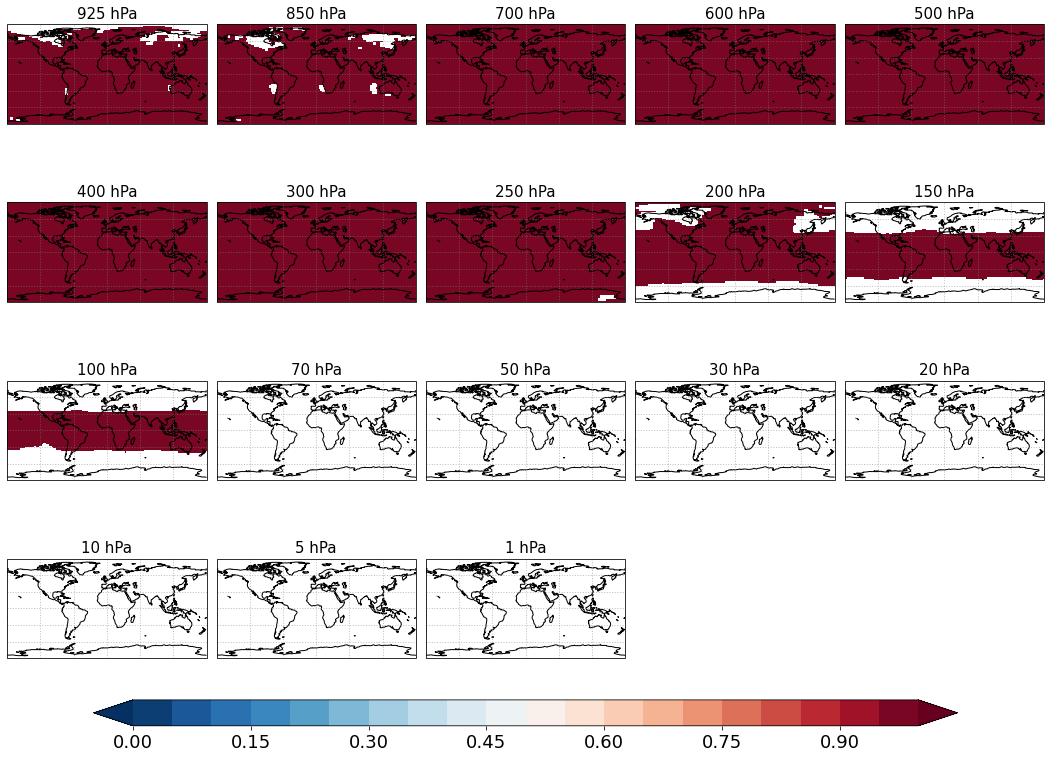

In [26]:
mm = mask.groupby('time.month').mean().compute()
ctl.plot_multimap_contour([mm.isel(month = 0, plev = i) for i in range(len(mm.plev))], cbar_range = (0, 1), subtitles = [f'{int(lev.values/100)} hPa' for lev in mm.plev])

## Calculating surface pressure mask
Vertical integration starts from surface pressure

In [8]:
ps = xr.open_mfdataset('/home/fabiano/work_big/irods_move/stabilization-hist-1990/r1i1p1f1/Amon/ps/ps_Amon_EC-Earth3_stabilization-hist-1990_r1i1p1f1_gr_199?01-199?12.nc')
psclim = ps.groupby('time.month').mean()
psye = psclim['ps'].mean('month')
psye_rg = ctl.regrid_dataset(psye, k.lat, k.lon)

Regridding...
Regridding completed in 0:00:04.225046


Adding cyclic point



<GeoAxesSubplot:>

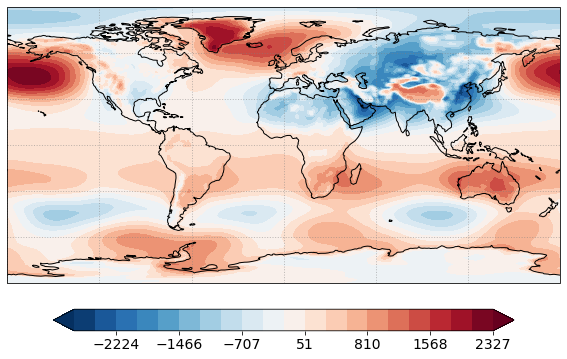

In [48]:
ctl.plot_map_contour(psclim['ps'][6]-psclim['ps'][0])

Adding cyclic point



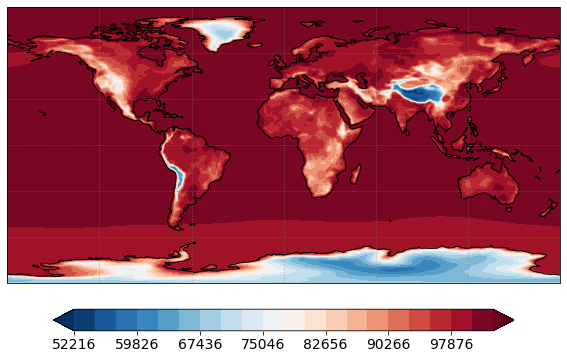

In [49]:
fig = ctl.plot_map_contour(psye)

In [50]:
ps2 = xr.open_mfdataset('/home/fabiano/work_big/irods_move/stabilization-ssp585-2100/r1i1p1f1/Amon/ps/ps_Amon_EC-Earth3_stabilization-ssp585-2100_r1i1p1f1_gr_300?01-300?12.nc')
psclim2 = ps2.groupby('time.month').mean()
psye2 = psclim2['ps'].mean('month')

/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/home/fabian

Adding cyclic point



<GeoAxesSubplot:>

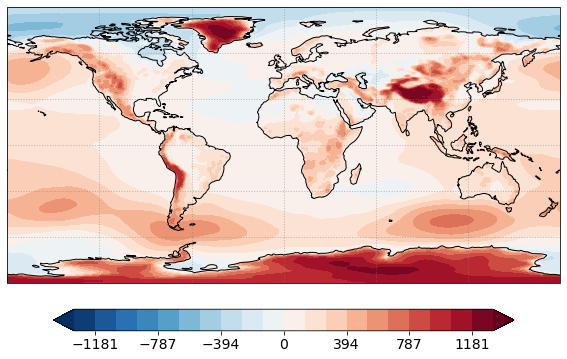

In [51]:
ctl.plot_map_contour(psye2-psye, plot_anomalies=True)

In [13]:
var

NameError: name 'var' is not defined

In [52]:
vlevs.player

<xarray.DataArray 'player' (player: 24)>
array([1000. ,  975. ,  950. ,  925. ,  900. ,  875. ,  850. ,  825. ,  800. ,
        775. ,  725. ,  625. ,  525. ,  425. ,  325. ,  237.5,  187.5,  137.5,
         85. ,   40. ,   15. ,    6. ,    2.5,    1. ], dtype=float32)
Coordinates:
  * player   (player) float32 1e+03 975.0 950.0 925.0 900.0 ... 15.0 6.0 2.5 1.0
Attributes:
    units:    hPa

In [9]:
psye_rg = psye_rg.compute()

In [10]:
### Mask for surf pressure

wid_mask = np.empty([len(vlevs.player)] + list(psye_rg.shape))

# for ii, (lev, wid) in enumerate(zip(vlevs.player, vlevs.dp)):
#     ps_mask[ii] = psye - lev
#     ps_mask[ps_mask < 0.] = np.nan

for ila in range(len(psye_rg.lat)):
    #print(ila)
    for ilo in range(len(psye_rg.lon)):
        ind = np.where((psye_rg[ila, ilo].values/100. - vlevs.player.values) > 0)[0][0]
        wid_mask[:ind, ila, ilo] = np.nan
        wid_mask[ind, ila, ilo] = psye_rg[ila, ilo].values/100. - vlevs.player.values[ind]
        wid_mask[ind+1:, ila, ilo] = vlevs.dp.values[ind+1:]



In [22]:
k.coords

Coordinates:
  * player   (player) float32 1e+03 975.0 950.0 925.0 900.0 ... 15.0 6.0 2.5 1.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [21]:
k.dims[1:], k.drop('month').coords

(('player', 'lat', 'lon'),
 Coordinates:
   * player   (player) float32 1e+03 975.0 950.0 925.0 900.0 ... 15.0 6.0 2.5 1.0
   * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
   * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5)

In [23]:
wid_mask = xr.DataArray(wid_mask, dims = k.dims[1:], coords = k.drop('month').coords)

<xarray.DataArray (player: 24, lat: 73, lon: 144)>
array([[[14.14851562, 14.14851562, 14.14851562, ..., 14.14851562,
         14.14851562, 14.14851562],
        [13.78867187, 13.80796875, 13.82726562, ..., 13.4940625 ,
         13.59234375, 13.69054687],
        [13.22078125, 13.24703125, 13.27335938, ..., 13.3846875 ,
         13.2540625 , 13.23734375],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[25.        , 25.        , 25.        , ..., 25.        ,
         25.        , 25.        ],
        [25.        , 25.        , 25.        , ..., 25.        ,
         25.        , 25.        ],
        [25.        , 25.        , 25.        , ..., 25.        ,
         25.        , 25.        ],
...
        [ 2.5       ,  2.5       ,  2.5       , ...,  2.5       ,
          2.5       ,  2.5       ],
        [ 2.5       ,  2.5       ,  2.5       , ...,  2.5       ,
          2.5       ,  2.5       ],
        [ 2.5       ,  2.5       ,  2.5       , ...,  2.5       ,
          2.5       ,  2.5       ]],

       [[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ]]])
Coordinates:
  * player   (player) float32 1e+03 975.0 950.0 925.0 900.0 ... 15.0 6.0 2.5 1.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [55]:
pickle.dump([mask, wid_mask], open(cart_out + 'vmasks.p', 'wb'))

In [35]:
#mask, wid_mask = pickle.load(open(cart_out + 'vmasks.p', 'rb'))
_, wid_mask = pickle.load(open(cart_out + 'vmasks.p', 'rb'))

In [14]:
k

<xarray.DataArray 'lwkernel' (month: 12, player: 24, lat: 73, lon: 144)>
array([[[[-0.12999152, -0.12999152, -0.12999152, ..., -0.12999152,
          -0.12999152, -0.12999152],
         [-0.19185498, -0.19401191, -0.19958542, ..., -0.13998711,
          -0.15818982, -0.17377296],
         [-0.17979659, -0.1809967 , -0.18491806, ..., -0.10767405,
          -0.1255646 , -0.14942032],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[-0.16088872, -0.16088872, -0.16088872, ..., -0.16088872,
          -0.16088872, -0.16088872],
         [-0.19378865, -0.19612959, -0.19789582, ..., -0.18038964,
          -0.18624678, -0.18992253],
         [-0.15465379, -0.1493172 , -0.14381392, ..., -0.149425  ,
          -0.15495896, -0.15366349],
...
         [-1.6109688 , -1.6114068 , -1.6114979 , ..., -1.6103978 ,
          -1.6106218 , -1.610858  ],
         [-1.6129352 , -1.612694  , -1.6129647 , ..., -1.6125414 ,
          -1.6127753 , -1.6124897 ],
         [-1.6131936 , -1.6132009 , -1.6131985 , ..., -1.6131936 ,
          -1.6131961 , -1.6131936 ]],

        [[-2.2988966 , -2.2988966 , -2.2988966 , ..., -2.2988966 ,
          -2.2988966 , -2.2988966 ],
         [-2.3069015 , -2.3097744 , -2.312014  , ..., -2.2983122 ,
          -2.3013024 , -2.303462  ],
         [-2.31949   , -2.3244672 , -2.3291616 , ..., -2.3011608 ,
          -2.3073504 , -2.314457  ],
         ...,
         [-3.6839638 , -3.6843023 , -3.6843886 , ..., -3.6815274 ,
          -3.6819582 , -3.6830595 ],
         [-3.7104084 , -3.7103467 , -3.7108514 , ..., -3.7100391 ,
          -3.71063   , -3.7105806 ],
         [-3.724535  , -3.7245474 , -3.7245781 , ..., -3.7245412 ,
          -3.7245536 , -3.7245412 ]]]], dtype=float32)
Coordinates:
  * player   (player) float32 1e+03 975.0 950.0 925.0 900.0 ... 15.0 6.0 2.5 1.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    longname:  t kernel at TOA in all sky
    units:     W/m2/K/100mb

In [57]:
vlevs.dp

<xarray.DataArray 'dp' (player: 24)>
array([ 25.5,  25. ,  25. ,  25. ,  25. ,  25. ,  25. ,  25. ,  25. ,
        25. ,  87.5, 100. , 100. , 100. , 100. ,  62.5,  50. ,  50. ,
        52.5,  35. ,  16.5,   4.5,   2.5,   1. ], dtype=float32)
Coordinates:
  * player   (player) float32 1e+03 975.0 950.0 925.0 900.0 ... 15.0 6.0 2.5 1.0

In [30]:
wid_mask.shape

(24, 73, 144)

In [59]:
np.nanmin(wid_mask), np.nanmax(wid_mask)

(0.0014062499999454303, 100.0)

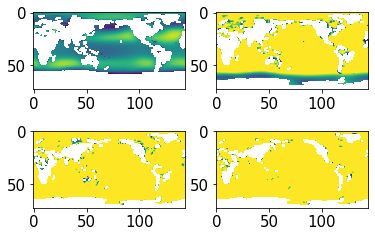

In [60]:
fig, axs = plt.subplots(2,2)

axs[0,0].imshow(wid_mask[0], vmin = 0., vmax = 25.)
axs[0,1].imshow(wid_mask[1], vmin = 0., vmax = 25.)
axs[1,0].imshow(wid_mask[2], vmin = 0., vmax = 25.)
axs[1,1].imshow(wid_mask[3], vmin = 0., vmax = 25.)
#plt.colorbar()

In [ ]:
wid_mask

# Calculating feedbacks

In [27]:
feedbacks = dict()
feedbacks_month = dict()

cose = 100*vlevs.player

In [26]:
remove_pi_runmean = False # way to compute anomalies: against 20-yr running mean of the picontrol simulation (True) or against picontrol climatology (False)
n_runmean = 20

save_monthly = True

In [14]:
from importlib import reload
reload(ctl)

No DISPLAY variable set. Switching to agg backend


<module 'climtools.climtools_lib' from '/home/fabiano/Research/git/ClimTools/climtools/climtools_lib.py'>

In [32]:
#calcolo per ts_anom e gtas
vnam = 'ts'

filist = glob.glob(filin_4c.format(vnam))
filist.sort()
var = xr.open_mfdataset(filist[:num_year])
print(len(filist))

if remove_pi_runmean:
    filist = glob.glob(filin_pi.format(vnam))
    filist.sort()
    pivar = xr.open_mfdataset(filist, chunks = {'time': 60}, use_cftime=True)[vnam]
    pivar = pivar.sel(time = slice('2540-01-01', '2689-12-31')).drop('time') # dropping time axis to allow subtraction
    if len(pivar['time']) != len(var['time']): 
        raise ValueError('different length of PI and 4xco2!')
    else:
        pivar['time'] = var['time']
else:
    pivar = piclim[vnam]

piok = ctl.regrid_dataset(pivar, k.lat, k.lon)
var = ctl.regrid_dataset(var[vnam], k.lat, k.lon) 

if remove_pi_runmean:
    anoms = var - ctl.running_mean(piok, 12*n_runmean)
else:
    anoms = xr.apply_ufunc(lambda x, mean: x - mean, var.groupby('time.month'), piok, dask = 'allowed')

for tip in ['clr', 'cld']:
    kernel = allkers[(tip, 'ts')].lwkernel
    print(kernel.shape)

    dRt = xr.apply_ufunc(lambda x, ker: x*ker, anoms.groupby('time.month'), kernel, dask = 'allowed')

    dRt_glob = ctl.global_mean(dRt.groupby('time.year').mean('time'))
    feedbacks[( tip, 'planck-surf')] = dRt_glob.compute()

    if save_monthly:
        dRt_glob_month = ctl.global_mean(dRt)
        feedbacks_month[( tip, 'planck-surf')] = dRt_glob_month.compute()

anoms.compute()
ts_anom = anoms
g_ts = ctl.global_mean(anoms).groupby('time.year').mean('time')

#pickle.dump(gtas, open(cart_out + 'feedback_gtas.p', 'wb'))
#pickle.dump(ts_anom, open(cart_out + 'ts_anom.p', 'wb'))               

165
Regridding...
Regridding completed in 0:00:00.179145
Regridding...
Regridding completed in 0:00:00.175311
(12, 73, 144)
(12, 73, 144)


### Atmospheric Planck and lapse-rate

In [39]:
filist = glob.glob(filin_4c.format('ta'))
filist.sort()
var = xr.open_mfdataset(filist[:num_year], chunks = {'time': 60})
print(1, type(var['ta'].data))
var = var['ta']
var = ctl.regrid_dataset(var, k.lat, k.lon)
print(2, type(var.data))

# pimean[('ta')] = pickle.load(open(cart_out + 'pimean/pimean_ta.p', 'rb'))
# pivar = ctl.regrid_dataset(pimean[('ta')], k.lat, k.lon)

if remove_pi_runmean:
    filist = glob.glob(filin_pi.format(vnam))
    filist.sort()
    pivar = xr.open_mfdataset(filist[:num_year], chunks = {'time': 60})['ta']
    piok = ctl.regrid_dataset(pivar, k.lat, k.lon)
else:
    pivar = ctl.regrid_dataset(piclim[('ta')], k.lat, k.lon)
    piok = pivar#.compute()
    #var = var.compute()

print(var.shape)

ta_abs = var.interp(plev = cose)
ta_abs_pi = pivar.interp(plev = cose)

# calculating anomaly
anoms_ok = xr.apply_ufunc(lambda x, mean: x - mean, var.groupby('time.month'), piok, dask = 'allowed')

anoms_ok_wstrat = anoms_ok.interp(plev = cose) # including stratosphere
anoms_ok = (anoms_ok*mask).interp(plev = cose) # without stratosphere

print(anoms_ok.shape)

for tip in ['clr','cld']:
    kernel = allkers[(tip, 't')].lwkernel
    
    ### Field anomalies
    # first method: removing surface response
    anoms_lr = (anoms_ok - ts_anom)#.compute()
    anoms_unif = (anoms_ok - anoms_lr)#.compute() # anoms_unif == ts_anom, trick to preserve dimensions

    ### Radiative anomalies

    ## 0: first method, excluding levels below surface pressure (best)
    dRt_unif = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, anoms_unif.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed')).sum('player')
    dRt_lr = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, anoms_lr.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed')).sum('player')

    ## 1: first method, all levels
    dRt_unif_1 = (xr.apply_ufunc(lambda x, ker: x*ker, anoms_unif.groupby('time.month'), kernel, dask = 'allowed') * vlevs.dp / 100.).sum('player')
    dRt_lr_1 = (xr.apply_ufunc(lambda x, ker: x*ker, anoms_lr.groupby('time.month'), kernel, dask = 'allowed') * vlevs.dp / 100.).sum('player')

    del anoms_lr, anoms_unif

    # second method: removing uniform atm. response
    anoms_lr_2 = (anoms_ok - anoms_ok.mean('player'))#.compute()
    anoms_unif_2 = (anoms_ok - anoms_lr_2)#.compute()

    ## 2: second method, all levels
    dRt_unif_2 = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, anoms_unif_2.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed') * vlevs.dp / 100.).sum('player')
    dRt_lr_2 = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, anoms_lr_2.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed') * vlevs.dp / 100.).sum('player')

    del anoms_lr_2, anoms_unif_2

    # third method: as first, but with stratosphere included
    anoms_lr_3 = (anoms_ok_wstrat - ts_anom)#.compute()
    anoms_unif_3 = (anoms_ok_wstrat - anoms_lr_3)#.compute()

    ## 3: third method, all levels
    dRt_unif_3 = (xr.apply_ufunc(lambda x, ker: x*ker, anoms_unif_3.groupby('time.month'), kernel, dask = 'allowed') * vlevs.dp / 100.).sum('player')
    dRt_lr_3 = (xr.apply_ufunc(lambda x, ker: x*ker, anoms_lr_3.groupby('time.month'), kernel, dask = 'allowed') * vlevs.dp / 100.).sum('player')

    del anoms_lr_3, anoms_unif_3

    dRt_unif_glob = ctl.global_mean(dRt_unif.groupby('time.year').mean('time'))
    dRt_lr_glob = ctl.global_mean(dRt_lr.groupby('time.year').mean('time'))
    feedbacks[(tip, 'planck-atmo')] = dRt_unif_glob.compute()
    feedbacks[(tip, 'lapse-rate')] = dRt_lr_glob.compute()

    for enu, (c_uni, c_lr) in enumerate(zip([dRt_unif, dRt_unif_1, dRt_unif_2, dRt_unif_3], [dRt_lr, dRt_lr_1, dRt_lr_2, dRt_lr_3])):
        feedbacks[(tip, 'planck-atmo', 'method{}'.format(enu))] = ctl.global_mean(c_uni.groupby('time.year').mean('time')).compute()
        feedbacks[(tip, 'lapse-rate', 'method{}'.format(enu))] = ctl.global_mean(c_lr.groupby('time.year').mean('time')).compute()
    
    if save_monthly:
        dRt_unif_glob_month = ctl.global_mean(dRt_unif)
        dRt_lr_glob_month = ctl.global_mean(dRt_lr)
        feedbacks_month[(tip, 'planck-atmo')] = dRt_unif_glob_month.compute()
        feedbacks_month[(tip, 'lapse-rate')] = dRt_lr_glob_month.compute()

        for enu, (c_uni, c_lr) in enumerate(zip([dRt_unif, dRt_unif_1, dRt_unif_2, dRt_unif_3], [dRt_lr, dRt_lr_1, dRt_lr_2, dRt_lr_3])):
            feedbacks_month[(tip, 'planck-atmo', 'method{}'.format(enu))] = ctl.global_mean(c_uni).compute()
            feedbacks_month[(tip, 'lapse-rate', 'method{}'.format(enu))] = ctl.global_mean(c_lr).compute()


1 <class 'dask.array.core.Array'>
Regridding...
Regridding completed in 0:00:00.902141
2 <class 'dask.array.core.Array'>
Regridding...
Regridding completed in 0:00:01.092098
(1800, 19, 73, 144)


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  retur

(1800, 24, 73, 144)


KeyboardInterrupt: 

In [ ]:
del var, pivar
del anoms_ok, anoms_ok_wstrat
#del anoms_unif, anoms_lr, anoms_unif_2, anoms_lr_2, anoms_unif_3, anoms_lr_3
import gc
gc.collect()

In [23]:
%matplotlib inline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


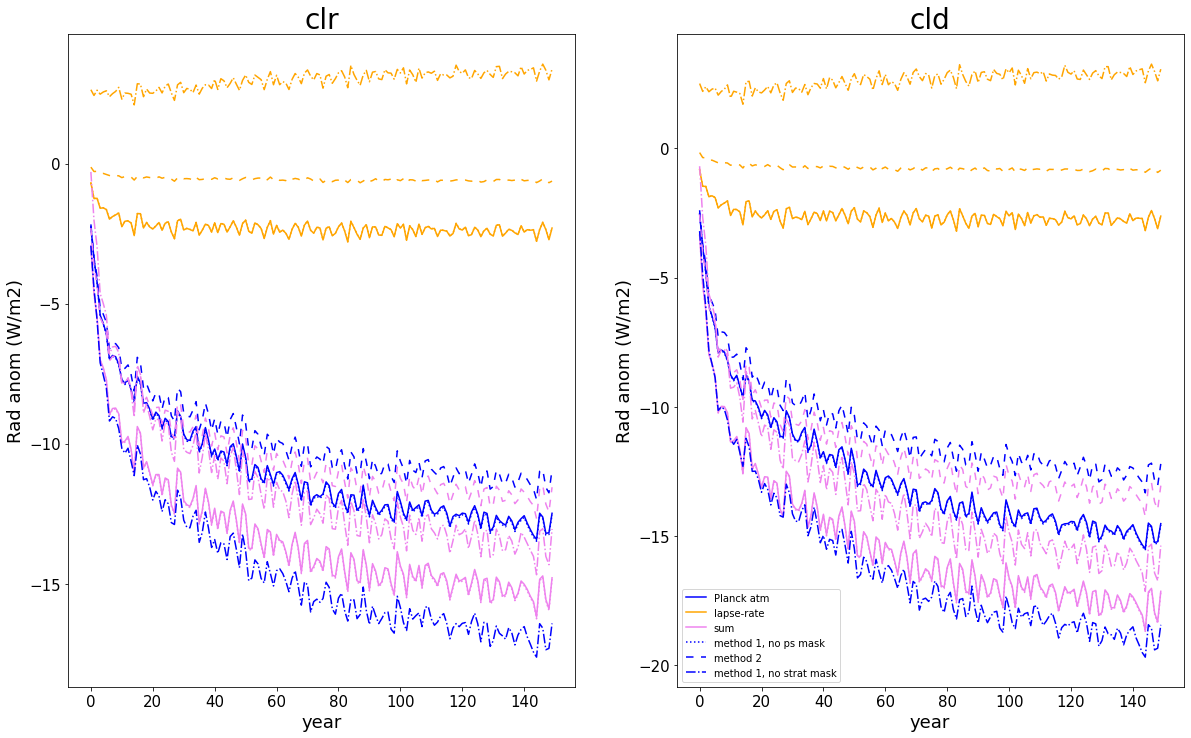

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (20,12))

for tip, ax in zip(['clr', 'cld'], axs):
    ax.plot(feedbacks[(tip, 'planck-atmo')], color = 'blue', label = 'Planck atm')
    ax.plot(feedbacks[(tip, 'lapse-rate')], color = 'orange', label = 'lapse-rate')
    ax.plot(feedbacks[(tip, 'planck-atmo')] + feedbacks[(tip, 'lapse-rate')], color = 'violet', label = 'sum')

    for mtd, ls, lab in zip(range(1, 4), [':', '--', '-.'], ['method 1, no ps mask', 'method 2', 'method 1, no strat mask']):
        ax.plot(feedbacks[(tip, 'planck-atmo', 'method{}'.format(mtd))], color = 'blue', ls = ls, label = lab)
        ax.plot(feedbacks[(tip, 'lapse-rate', 'method{}'.format(mtd))], color = 'orange', ls = ls)
        ax.plot(feedbacks[(tip, 'lapse-rate', 'method{}'.format(mtd))] + feedbacks[(tip, 'planck-atmo', 'method{}'.format(mtd))], color = 'violet', ls = ls)
    
    plt.legend()
    ax.set_ylabel('Rad anom (W/m2)')
    ax.set_xlabel('year')
    ax.set_title(tip)

fig.savefig(cart_out + 'planck_atm.pdf')

### Surface Planck

In [25]:
#calcolo planck-surf(ts) 

filist = glob.glob(filin_4c.format('ts'))
filist.sort()
var = xr.open_mfdataset(filist[:num_year])

#pimean[('ts')] = pickle.load(open(cart_out + 'pimean/pimean_ts.p', 'rb'))
#pivar = ctl.regrid_dataset(pimean[('ts')], k.lat, k.lon) 
pivar = ctl.regrid_dataset(piclim[('ts')], k.lat, k.lon) 
var = ctl.regrid_dataset(var['ts'], k.lat, k.lon) 

piok = pivar#.compute()
#var = var.compute()

anoms = xr.apply_ufunc(lambda x, mean: x - mean, var.groupby('time.month'), piok, dask = 'allowed')
#anoms.compute()

for tip in ['clr', 'cld']:
    kernel = allkers[(tip, 'ts')].lwkernel

    dRt = xr.apply_ufunc(lambda x, ker: x*ker, anoms.groupby('time.month'), kernel, dask = 'allowed').groupby('time.year').mean('time')

    dRt_glob = ctl.global_mean(dRt)
    feedbacks[( tip, 'planck-surf')] = dRt_glob.compute()           

Regridding...
Regridding completed in 0:00:00.158487
Regridding...


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/dask/array/core.py:454: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


Regridding completed in 0:00:01.426485


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


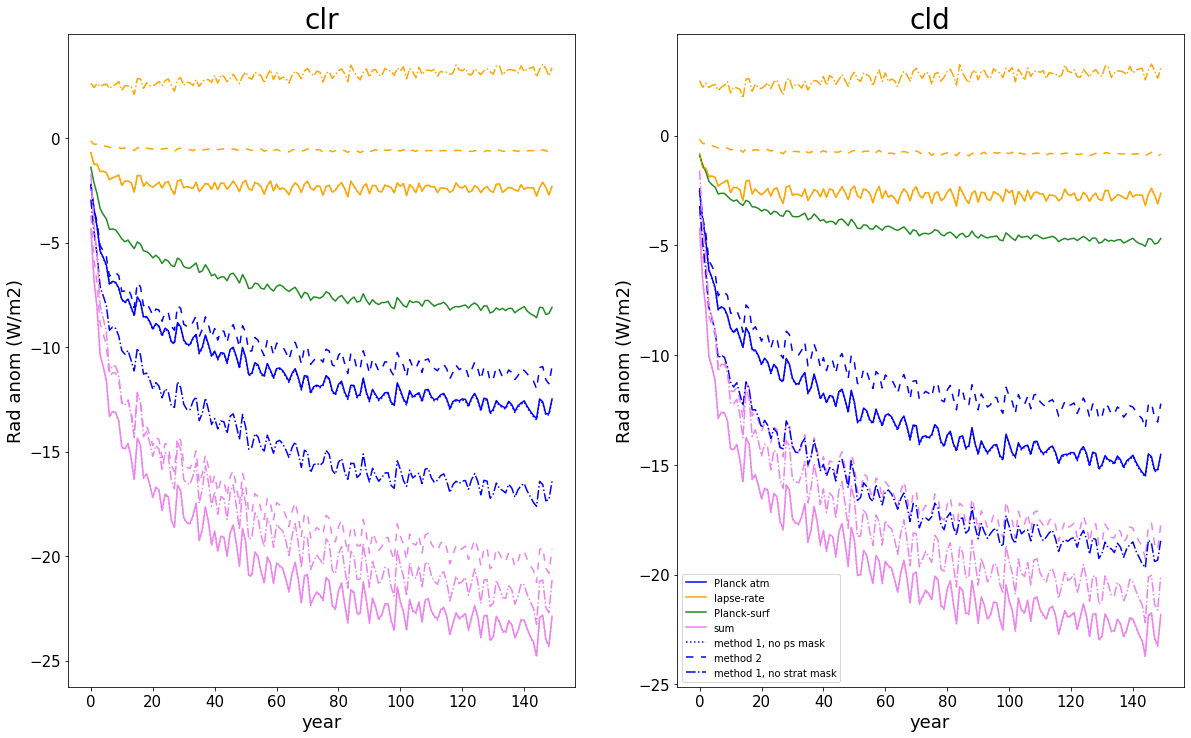

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (20,12))

for tip, ax in zip(['clr', 'cld'], axs):
    ax.plot(feedbacks[(tip, 'planck-atmo')], color = 'blue', label = 'Planck atm')
    ax.plot(feedbacks[(tip, 'lapse-rate')], color = 'orange', label = 'lapse-rate')
    ax.plot(feedbacks[(tip, 'planck-surf')], color = 'forestgreen', label = 'Planck-surf')
    ax.plot(feedbacks[(tip, 'planck-atmo')] + feedbacks[(tip, 'lapse-rate')] + feedbacks[(tip, 'planck-surf')], color = 'violet', label = 'sum')

    for mtd, ls, lab in zip(range(1, 4), [':', '--', '-.'], ['method 1, no ps mask', 'method 2', 'method 1, no strat mask']):
        ax.plot(feedbacks[(tip, 'planck-atmo', 'method{}'.format(mtd))], color = 'blue', ls = ls, label = lab)
        ax.plot(feedbacks[(tip, 'lapse-rate', 'method{}'.format(mtd))], color = 'orange', ls = ls)
        ax.plot(feedbacks[(tip, 'lapse-rate', 'method{}'.format(mtd))] + feedbacks[(tip, 'planck-atmo', 'method{}'.format(mtd))] + feedbacks[(tip, 'planck-surf')], color = 'violet', ls = ls)
    
    plt.legend()
    ax.set_ylabel('Rad anom (W/m2)')
    ax.set_xlabel('year')
    ax.set_title(tip)

fig.savefig(cart_out + 'planck_atm_surf.pdf')

### Water-vapor feedback

In [7]:
# dlnws function from Huang
import dask.array as da

def pliq(T):
    pliq = 0.01 * np.exp(54.842763 - 6763.22 / T - 4.21 * np.log(T) + 0.000367 * T + np.tanh(0.0415 * (T - 218.8)) * (53.878 - 1331.22 / T - 9.44523 * np.log(T) + 0.014025 * T))
    return pliq

def pice(T):
    pice = np.exp(9.550426 - 5723.265 / T + 3.53068 * np.log(T) - 0.00728332 * T) / 100.0
    return pice

def dlnws(T):
    """
    Calculates 1/(dlnq/dT_1K).
    """
    pliq0 = pliq(T)
    pice0 = pice(T)

    T1 = T + 1.0
    pliq1 = pliq(T1)
    pice1 = pice(T1)
    
    # Use np.where to choose between pliq and pice based on the condition T >= 273
    if isinstance(T, da.core.Array):
        ws = da.where(T >= 273, pliq0, pice0)    # Dask equivalent of np.where is da.where
        ws1 = da.where(T1 >= 273, pliq1, pice1)
    else:
        ws = np.where(T >= 273, pliq0, pice0)
        ws1 = np.where(T1 >= 273, pliq1, pice1)
    
    # Calculate the inverse of the derivative dws
    dws = ws / (ws1 - ws)

    if isinstance(dws, np.ndarray):
        dws = ctl.transform_to_dataarray(T, dws, 'dlnws')
    
    return dws

In [5]:
%matplotlib inline

In [5]:
def pliq_simp(t, pres = 100000.):
    tzer = 273.15
    es = 610.94*np.exp(17.625*(t-tzer)/(t-tzer+243.04))
    qs = 0.622 * es/pres
    return qs

def pice_simp(t, pres = 100000.):
    tzer = 273.15
    es = 611.21*np.exp(22.587*(t-tzer)/(t-tzer+273.86))
    qs = 0.622 * es/pres
    return qs


def dlnws_simp(T):
    """
    Calculates 1/(dlnq/dT_1K).
    """
    pliq0 = pliq_simp(T)
    pice0 = pice_simp(T)

    T1 = T + 1.0
    pliq1 = pliq_simp(T1)
    pice1 = pice_simp(T1)
    
    # Use np.where to choose between pliq and pice based on the condition T >= 273
    if isinstance(T, da.core.Array):
        ws = da.where(T >= 273, pliq0, pice0)    # Dask equivalent of np.where is da.where
        ws1 = da.where(T1 >= 273, pliq1, pice1)
    else:
        ws = np.where(T >= 273, pliq0, pice0)
        ws1 = np.where(T1 >= 273, pliq1, pice1)
    
    # Calculate the inverse of the derivative dws
    dws = ws / (ws1 - ws)

    if isinstance(dws, np.ndarray):
        dws = ctl.transform_to_dataarray(T, dws, 'dlnws')
    
    return dws

In [ ]:
def pliq_simp(t, pres = 100000.):
    tzer = 273.15
    es = 610.94*np.exp(17.625*(t-tzer)/(t-tzer+243.04))
    qs = 0.622 * es/pres
    return qs

In [ ]:
def calc_es(t):
    tzer = 273.15
    es = 610.94*np.exp(17.625*(t-tzer)/(t-tzer+243.04))
    return es

dlnq_1K = np.log(calc_es(t0_1K)/calc_es(t0))

In [ ]:
deltalog = lnqs(+1) - lnqs(0)
deltalog = ln(es(+1)/pres) - ln(es(0)/pres) = ln(es(+1)/es(0))

delta = qs(+1) - qs(0)
delta = (es(+1) - es(0))/pres = qs(0)/0.622 * (es(+1) - es(0))/es(0)

In [18]:
pliq_simp(303)

0.026125695063680638

In [9]:
%matplotlib inline

1.5037100542156472
1.327660497138451


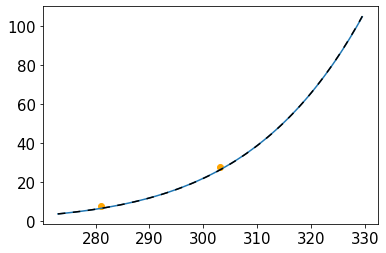

In [10]:
tgri = np.arange(273., 330., 0.5)
pliqcos = np.array([pliq(ti) for ti in tgri])
plt.plot(tgri, 0.622*pliqcos)
plt.plot(tgri, 1000.*pliq_simp(tgri), color = 'black', ls = '--')
plt.scatter(303., 28., color = 'orange')
plt.scatter(281., 8., color = 'orange')

print(pliq(303.)/28.)
print(pliq(281.)/8.)



In [27]:
import gc
gc.collect()

495

In [7]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       3.2Gi        26Gi        21Mi       1.9Gi        27Gi
Swap:          15Gi       2.9Gi        12Gi


In [16]:
filist = glob.glob(filin_4c.format('hus'))
filist.sort()
var = xr.open_mfdataset(filist[:num_year], chunks={'time': 60})
var = var['hus']
var = ctl.regrid_dataset(var, k.lat, k.lon)
# pimean[('hus')] = pickle.load(open(cart_out + 'pimean/pimean_hus.p', 'rb'))
# pivar = ctl.regrid_dataset(pimean[('hus')], k.lat, k.lon)
pivar = ctl.regrid_dataset(piclim[('hus')], k.lat, k.lon)
piok = pivar#.compute()

#var = var.compute()

Rv = 487.5 # gas constant of water vapor
Lv = 2.5e+06 # latent heat of water vapor

for tip in ['clr','cld']:
    kernel_lw = allkers[(tip, 'wv_lw')].lwkernel
    kernel_sw = allkers[(tip, 'wv_sw')].swkernel
    kernel = kernel_lw #+ kernel_sw

    var_int = (var*mask).interp(plev = cose)
    piok_int = piok.interp(plev = cose)

    # Method 0, 1, 2: using normalized difference (following Huang H. & Huang Y., 2023)
    anoms_ok1 = xr.apply_ufunc(lambda x, mean: (x - mean)/mean, var_int.groupby('time.month'), piok_int, dask = 'allowed')

    coso = xr.apply_ufunc(lambda x, ta: x*ta, anoms_ok1.groupby('time.month'), ta_abs_pi**2, dask = 'allowed')#.compute() 
    # Method 0: using unperturbed T0 from pi
    dRt = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, coso.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed') * Rv/Lv).sum('player')

    # Method 1: as 0, but without surface pressure mask
    dRt_1 = (xr.apply_ufunc(lambda x, ker: x*ker, coso.groupby('time.month'), kernel, dask = 'allowed') * Rv/Lv * vlevs.dp / 100.).sum('player')

    del anoms_ok1, coso

    # Method 3: using log difference (following Huang X.)
    anoms_ok3 = xr.apply_ufunc(lambda x, mean: np.log(x) - np.log(mean), var_int.groupby('time.month'), piok_int, dask = 'allowed')

    coso2 = xr.apply_ufunc(lambda x, ta: x*ta, anoms_ok3.groupby('time.month'), ta_abs_pi**2, dask = 'allowed')#.compute() # Method 3 (using simple formula)
    coso3 = xr.apply_ufunc(lambda x, ta: x*ta, anoms_ok3.groupby('time.month'), dlnws(ta_abs_pi), dask = 'allowed')#.compute() # Method 3 (using dlnws)
    
    # Method 2: using log difference (with simple formula for dlnws)
    dRt_2 = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, coso2.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed') * Rv/Lv).sum('player')
    
    # Method 3: using log difference (following Huang Y. 2017 with dlnws function)
    dRt_3 = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, coso3.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed')).sum('player')

    del anoms_ok3, coso2, coso3

    # Method 4: as method 0, but including stratosphere
    var_int_ws = var.interp(plev = cose)
    piok_int_ws = piok.interp(plev = cose)
    anoms_ok4 = xr.apply_ufunc(lambda x, mean: (x - mean)/mean, var_int_ws.groupby('time.month'), piok_int_ws, dask = 'allowed')
    coso4 = xr.apply_ufunc(lambda x, ta: x*ta, anoms_ok4.groupby('time.month'), ta_abs_pi**2, dask = 'allowed')#.compute() # Method 4

    dRt_4 = (xr.apply_ufunc(lambda x, ker, wid: x*ker*wid, coso4.groupby('time.month'), kernel, wid_mask/100., dask = 'allowed') * Rv/Lv).sum('player')

    del anoms_ok4, var_int_ws, piok_int_ws, coso4

    dRt_glob = ctl.global_mean(dRt.groupby('time.year').mean('time'))
    feedbacks[(tip, 'water-vapor')] = dRt_glob.compute()

    for enu, dr in enumerate([dRt, dRt_1, dRt_2, dRt_3, dRt_4]):
        feedbacks[(tip, 'water-vapor', 'method{}'.format(enu))] = ctl.global_mean(dr.groupby('time.year').mean('time')).compute()

    if save_monthly:
        dRt_glob_month = ctl.global_mean(dRt)
        feedbacks_month[(tip, 'water-vapor')] = dRt_glob_month.compute()

        for enu, dr in enumerate([dRt, dRt_1, dRt_2, dRt_3, dRt_4]):
            feedbacks_month[(tip, 'water-vapor', 'method{}'.format(enu))] = ctl.global_mean(dr).compute()

         

Regridding...
Regridding completed in 0:00:00.222833
Regridding...
Regridding completed in 0:00:00.250690


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


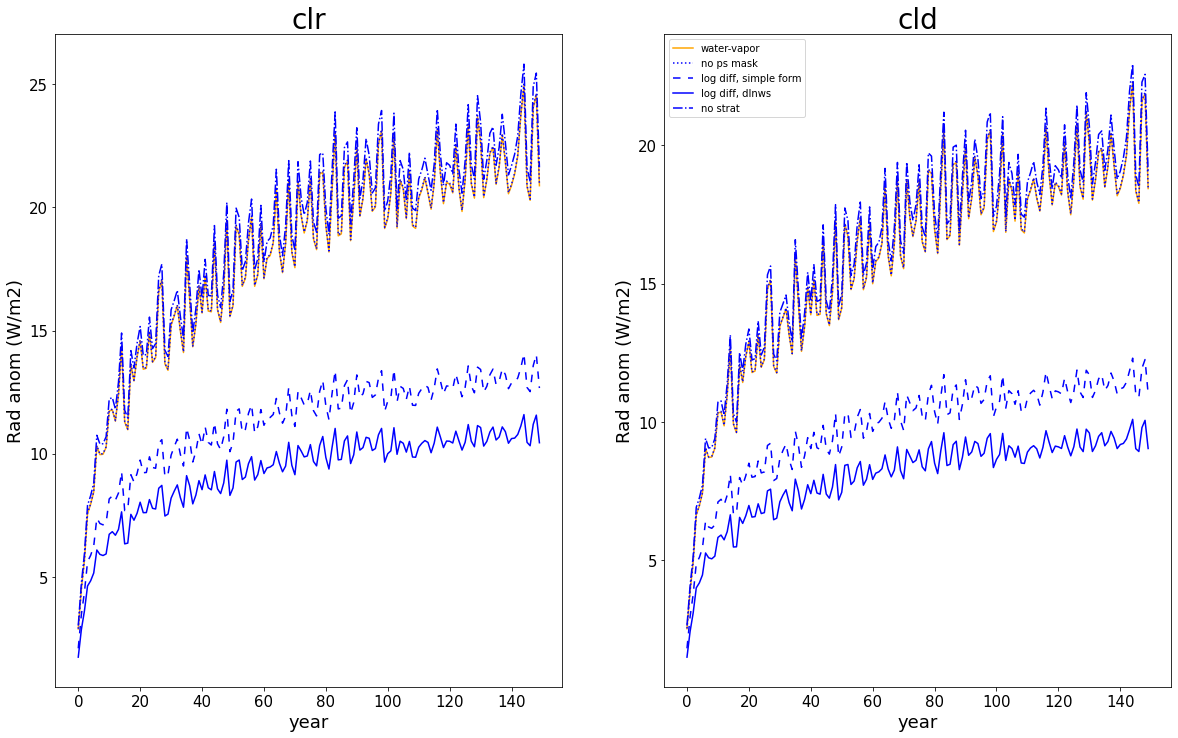

In [48]:
fig, axs = plt.subplots(1, 2, figsize = (20,12))

for tip, ax in zip(['clr', 'cld'], axs):
    ax.plot(feedbacks[(tip, 'water-vapor')], color = 'orange', label = 'water-vapor')

    for mtd, ls, lab in zip(range(1, 5), [':', '--', '-', '-.'], ['no ps mask', 'log diff, simple form', 'log diff, dlnws',  'no strat']):
        ax.plot(feedbacks[(tip, 'water-vapor', 'method{}'.format(mtd))], color = 'blue', ls = ls, label = lab)

    #ax.plot(feedbacks[(tip, 'water-vapor', 'method3')], color = 'black', ls = ':', label = 'log diff/log2')
    
    plt.legend()
    ax.set_ylabel('Rad anom (W/m2)')
    ax.set_xlabel('year')
    ax.set_title(tip)

fig.savefig(cart_out + 'water-vapor.pdf')

### Albedo feedback

In [17]:
for tip in ['clr', 'cld']:
    filist_1 = glob.glob(filin_4c.format('rsus'))
    filist_1.sort()
    var_rsus = xr.open_mfdataset(filist_1[:num_year], chunks = {'time': 60})['rsus']
    filist_2 = glob.glob(filin_4c.format('rsds'))
    filist_2.sort()
    var_rsds = xr.open_mfdataset(filist_2[:num_year], chunks = {'time': 60})['rsds']
    var = var_rsus/var_rsds

    var = ctl.regrid_dataset(var, k.lat, k.lon)
    #pimean[('alb')] = pickle.load(open(cart_out + 'pimean/pimean_alb.p', 'rb'))
    #pivar = ctl.regrid_dataset(pimean[('alb')], k.lat, k.lon) 
    pivar = ctl.regrid_dataset(piclim[('alb')], k.lat, k.lon)

    piok = pivar#.compute()
    #var = var.compute()

    # Removing inf and nan from alb
    piok = piok.where(piok > 0., 0.)
    var = var.where(var > 0., 0.)
    anoms = xr.apply_ufunc(lambda x, mean: x - mean, var.groupby('time.month'), piok, dask = 'allowed')

    kernel = allkers[(tip, 'alb')].swkernel
    dRt = xr.apply_ufunc(lambda x, ker: x*ker, anoms.groupby('time.month'), kernel, dask = 'allowed')
   
    dRt_glob = ctl.global_mean(dRt.groupby('time.year').mean('time')).compute()
    feedbacks[( tip, 'albedo')] = 100*dRt_glob

    if save_monthly:
        dRt_glob_month = ctl.global_mean(dRt).compute()
        feedbacks_month[( tip, 'albedo')] = 100*dRt_glob_month
    

Regridding...
Regridding completed in 0:00:00.232669
Regridding...
Regridding completed in 0:00:00.229959


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Regridding...
Regridding completed in 0:00:00.204325
Regridding...
Regridding completed in 0:00:00.207769


/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/fabiano/local_bin/anaconda3/envs/ctl4/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


### Computing net_toa (cld and clr) for sanity check

In [5]:
num_year = 150

In [18]:
filist_1 = glob.glob(filin_4c.format('rsut'))
filist_1.sort()
var_rsut = xr.open_mfdataset(filist_1[:num_year])['rsut']
filist_2 = glob.glob(filin_4c.format('rsdt'))
filist_2.sort()
var_rsdt = xr.open_mfdataset(filist_2[:num_year])['rsdt']
filist_1 = glob.glob(filin_4c.format('rlut'))
filist_1.sort()
var_rlut = xr.open_mfdataset(filist_1[:num_year])['rlut']

net_toa = var_rsdt - var_rsut - var_rlut
net_toa = net_toa.compute()
net_toa_glob = ctl.global_mean(net_toa)

In [19]:
pivar_nettoa = var_rsdt.mean('time') - ctl.regrid_dataset(pimean['rsut'], k.lat, k.lon) - ctl.regrid_dataset(pimean['rlut'], k.lat, k.lon)
pivar_nettoa_glob = ctl.global_mean(pivar_nettoa.compute())

Regridding...
Regridding completed in 0:00:00.222366
Regridding...
Regridding completed in 0:00:00.229979


In [20]:
dRt_glob_tot = net_toa_glob.groupby('time.year').mean()-pivar_nettoa_glob

In [ ]:
# import xesmf as xe

# regridder = xe.Regridder(rsutcs, k, method='bilinear')#, extrap_method="nearest_s2d", ignore_degenerate=True)
# pino = regridder(rsutcs)

In [21]:
filist = glob.glob(filin_4c1.format('rsutcs')) 
filist.sort()
rsutcs = xr.open_mfdataset(filist[:num_year])['rsutcs']
rsutcs= ctl.regrid_dataset(rsutcs, k.lat, k.lon)

filist = glob.glob(filin_4c1.format('rlutcs'))
filist.sort()
rlutcs = xr.open_mfdataset(filist[:num_year])['rlutcs']
rlutcs = ctl.regrid_dataset(rlutcs, k.lat, k.lon)

filist_2 = glob.glob(filin_4c.format('rsdt'))
filist_2.sort()
var_rsdt = xr.open_mfdataset(filist_2[:num_year])['rsdt']
rsdt = ctl.regrid_dataset(var_rsdt, k.lat, k.lon)

net_toa_cs = rsdt - rsutcs - rlutcs
net_toa_cs = net_toa_cs.compute()
net_toa_glob_cs = ctl.global_mean(net_toa_cs)

Regridding...
Regridding completed in 0:00:01.362408
Regridding...
Regridding completed in 0:00:01.341658
Regridding...
Regridding completed in 0:00:00.234532


In [22]:
pivar_nettoa_cs = rsdt.mean('time') - ctl.regrid_dataset(pimean['rsutcs'], k.lat, k.lon) - ctl.regrid_dataset(pimean['rlutcs'], k.lat, k.lon)
pivar_nettoa_glob_cs = ctl.global_mean(pivar_nettoa_cs.compute())

Regridding...
Regridding completed in 0:00:00.235164
Regridding...
Regridding completed in 0:00:00.228778


In [23]:
pivar_nettoa_cs_month = rsdt.groupby('time.month').mean() - ctl.regrid_dataset(piclim['rsutcs'], k.lat, k.lon) - ctl.regrid_dataset(piclim['rlutcs'], k.lat, k.lon)
pivar_nettoa_glob_cs_month = ctl.global_mean(pivar_nettoa_cs_month).compute()

Regridding...
Regridding completed in 0:00:00.226058
Regridding...
Regridding completed in 0:00:00.222613


In [24]:
dRt_glob_tot_cs = net_toa_glob_cs.groupby('time.year').mean()-pivar_nettoa_glob_cs

In [25]:
rlutcs_anom = rlutcs.groupby('time.month') - piclim['rlutcs']
rlutcs_anom_glob = ctl.global_mean(rlutcs_anom)

In [26]:
net_toa_cs_monthly_anom = net_toa_glob_cs.groupby('time.month') - pivar_nettoa_glob_cs_month

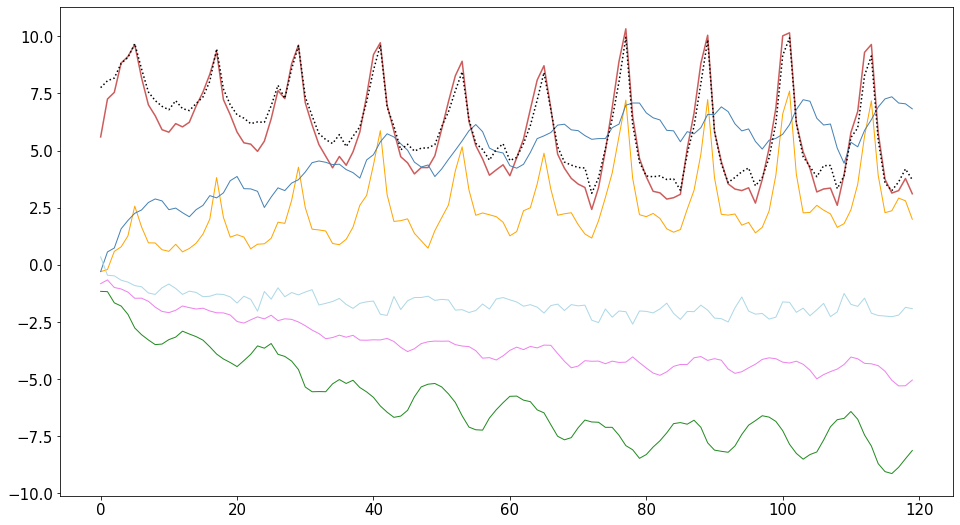

In [28]:
fig = plt.figure(figsize = (16,9))
plt.plot(net_toa_cs_monthly_anom, color = 'indianred')
tip = 'clr'
allfb = ['albedo', 'water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
colorz = ['orange', 'steelblue', 'lightblue', 'forestgreen', 'violet', 'pink']
for var, col in zip(allfb, colorz):
    if var == 'water-vapor':
        plt.plot(feedbacks_month[(tip, var, 'method3')], color = col, lw = 1, label = var)
    else:
        plt.plot(feedbacks_month[(tip, var)], color = col, lw = 1, label = var)

# plt.plot(feedbacks_month[(tip, 'water-vapor', 'method3')])
# plt.plot(feedbacks_month[(tip, 'lapse', 'method3')])
plt.plot(10 + np.sum([feedbacks_month[(tip, var)] for var in allfb], axis = 0) - feedbacks_month[(tip, 'water-vapor')] + feedbacks_month[(tip, 'water-vapor', 'method3')], color = 'black', ls = ':', label = 'all_3')

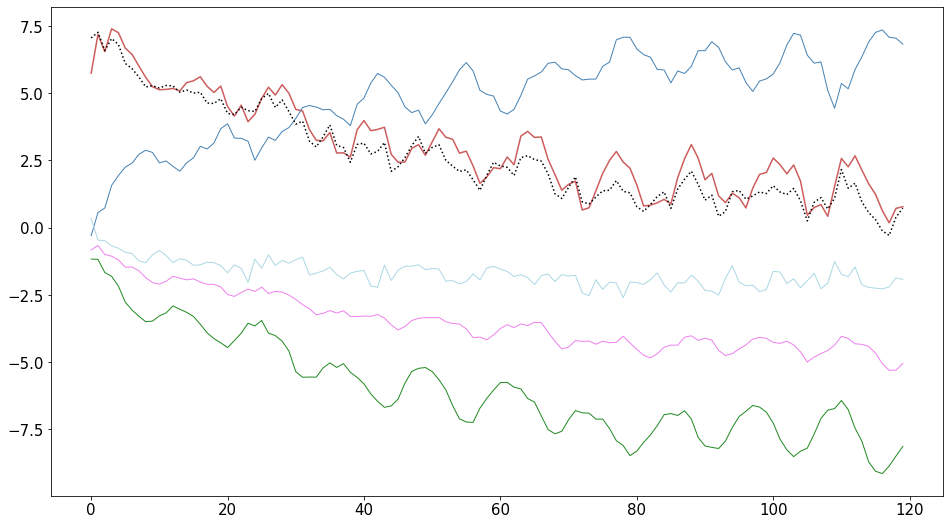

In [29]:
fig = plt.figure(figsize = (16,9))
plt.plot(-rlutcs_anom_glob, color = 'indianred')
tip = 'clr'
#allfb = ['albedo', 'water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
#colorz = ['orange', 'steelblue', 'lightblue', 'forestgreen', 'violet', 'pink']
allfb = ['water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
colorz = ['steelblue', 'lightblue', 'forestgreen', 'violet', 'pink']
for var, col in zip(allfb, colorz):
    if var == 'water-vapor':
        plt.plot(feedbacks_month[(tip, var, 'method3')], color = col, lw = 1, label = var)
    else:
        plt.plot(feedbacks_month[(tip, var)], color = col, lw = 1, label = var)

# plt.plot(feedbacks_month[(tip, 'water-vapor', 'method3')])
# plt.plot(feedbacks_month[(tip, 'lapse', 'method3')])
plt.plot(9 + np.sum([feedbacks_month[(tip, var)] for var in allfb], axis = 0) - feedbacks_month[(tip, 'water-vapor')] + feedbacks_month[(tip, 'water-vapor', 'method3')], color = 'black', ls = ':', label = 'all_3')

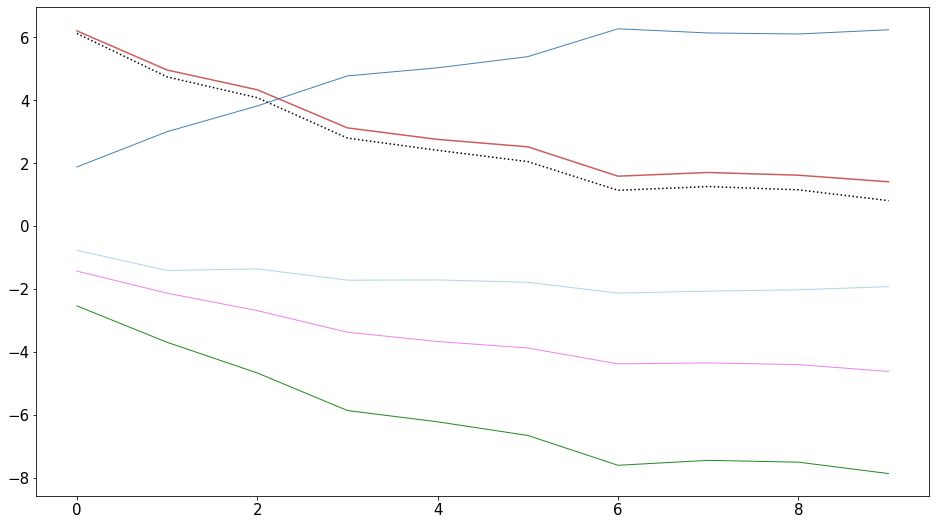

In [31]:
fig = plt.figure(figsize = (16,9))
plt.plot(-rlutcs_anom_glob.groupby('time.year').mean(), color = 'indianred')
tip = 'clr'
#allfb = ['albedo', 'water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
#colorz = ['orange', 'steelblue', 'lightblue', 'forestgreen', 'violet', 'pink']
allfb = ['water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
colorz = ['steelblue', 'lightblue', 'forestgreen', 'violet', 'pink']
for var, col in zip(allfb, colorz):
    if var == 'water-vapor':
        plt.plot(feedbacks_month[(tip, var, 'method3')].groupby('time.year').mean(), color = col, lw = 1, label = var)
    else:
        plt.plot(feedbacks_month[(tip, var)].groupby('time.year').mean(), color = col, lw = 1, label = var)

# plt.plot(feedbacks_month[(tip, 'water-vapor', 'method3')])
# plt.plot(feedbacks_month[(tip, 'lapse', 'method3')])
plt.plot(9 + np.sum([feedbacks_month[(tip, var)].groupby('time.year').mean() for var in allfb], axis = 0) - feedbacks_month[(tip, 'water-vapor')].groupby('time.year').mean() + feedbacks_month[(tip, 'water-vapor', 'method3')].groupby('time.year').mean(), color = 'black', ls = ':', label = 'all_3')

<xarray.DataArray ()>
array(7.29482447)
Coordinates:
    year     int64 1850 <xarray.DataArray ()>
array(17.05516828)


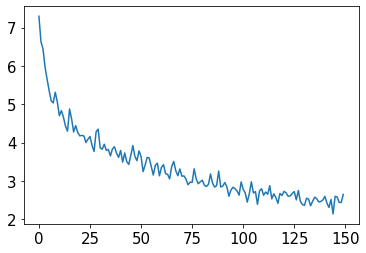

In [62]:
plt.plot(dRt_glob_tot_cs)
print(dRt_glob_tot_cs[0], pivar_nettoa_glob_cs)

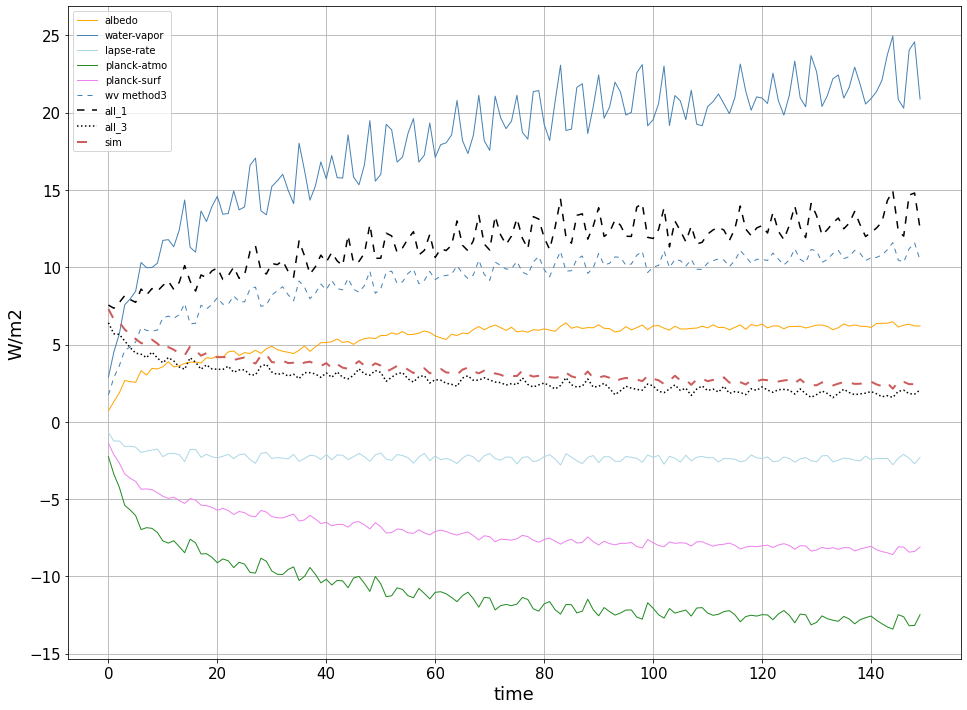

In [63]:
fig = plt.figure(figsize = (16,12))

tip = 'clr'

allfb = ['albedo', 'water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
colorz = ['orange', 'steelblue', 'lightblue', 'forestgreen', 'violet', 'pink']
for var, col in zip(allfb, colorz):
    plt.plot(feedbacks[(tip, var)], color = col, lw = 1, label = var)

plt.plot(feedbacks[(tip, 'water-vapor', 'method3')], color = 'steelblue', lw = 1, ls = '--', label = 'wv method3')

plt.plot(8.3 + np.sum([feedbacks[(tip, var)] for var in allfb], axis = 0), color = 'black', ls = '--', label = 'all_1')

plt.plot(8.3 + np.sum([feedbacks[(tip, var)] for var in allfb], axis = 0) - feedbacks[(tip, 'water-vapor')] + feedbacks[(tip, 'water-vapor', 'method3')], color = 'black', ls = ':', label = 'all_3')

# allfb = ['water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
# plt.plot(7.4 + np.sum([feedbacks[(tip, var)] for var in allfb], axis = 0), color = 'black', ls = ':', label = 'all_noalb')

plt.plot(dRt_glob_tot_cs, color = 'indianred', ls = '--', lw = 2, label = 'sim')
#plt.plot(dRt_glob_tot_cs + pivar_nettoa_glob_cs , color = 'indianred', ls = ':', lw = 2, label = 'sim')
plt.legend()
plt.grid()
plt.ylabel('W/m2')
plt.xlabel('time')

fig.savefig(cart_out + 'check_all_clr.pdf')

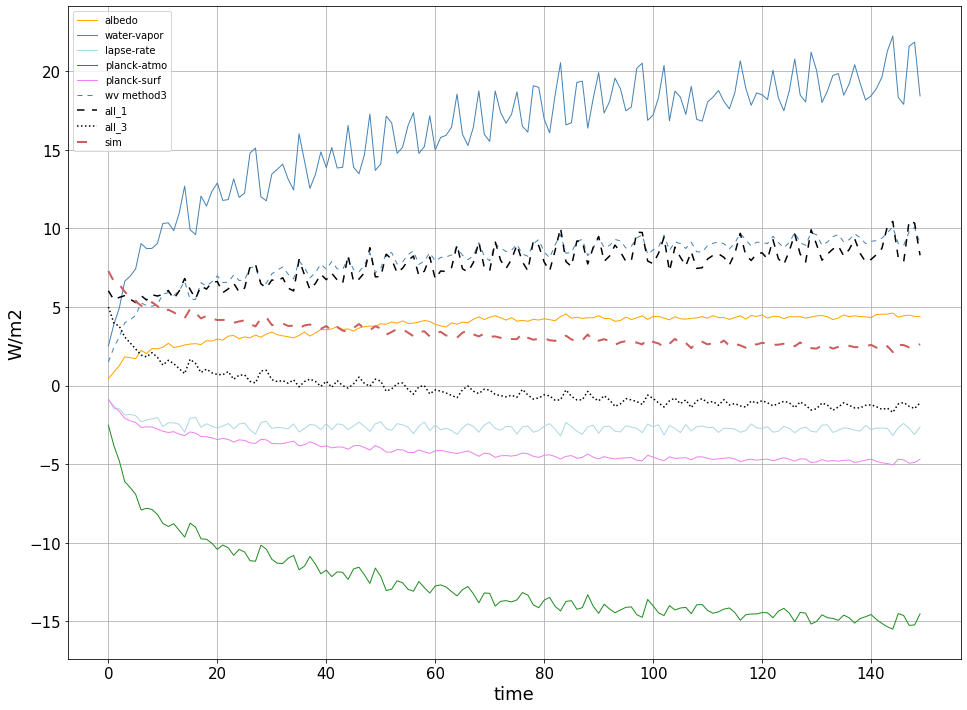

In [64]:
fig = plt.figure(figsize = (16,12))

tip = 'cld'

allfb = ['albedo', 'water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
colorz = ['orange', 'steelblue', 'lightblue', 'forestgreen', 'violet', 'pink']
for var, col in zip(allfb, colorz):
    plt.plot(feedbacks[(tip, var)], color = col, lw = 1, label = var)

plt.plot(feedbacks[(tip, 'water-vapor', 'method3')], color = 'steelblue', lw = 1, ls = '--', label = 'wv method3')

plt.plot(7.3 + np.sum([feedbacks[(tip, var)] for var in allfb], axis = 0), color = 'black', ls = '--', label = 'all_1')

plt.plot(7.3 + np.sum([feedbacks[(tip, var)] for var in allfb], axis = 0) - feedbacks[(tip, 'water-vapor')] + feedbacks[(tip, 'water-vapor', 'method3')], color = 'black', ls = ':', label = 'all_3')

# allfb = ['water-vapor', 'lapse-rate', 'planck-atmo', 'planck-surf']
# plt.plot(7.4 + np.sum([feedbacks[(tip, var)] for var in allfb], axis = 0), color = 'black', ls = ':', label = 'all_noalb')

plt.plot(dRt_glob_tot_cs, color = 'indianred', ls = '--', lw = 2, label = 'sim')
#plt.plot(dRt_glob_tot_cs + pivar_nettoa_glob_cs , color = 'indianred', ls = ':', lw = 2, label = 'sim')
plt.legend()
plt.grid()
plt.ylabel('W/m2')
plt.xlabel('time')

fig.savefig(cart_out + 'check_all_cld.pdf')

In [65]:
for tip in ['clr', 'cld']:
    feedbacks[(tip, 'water-vapor')] = feedbacks[(tip, 'water-vapor', 'method3')]

pickle.dump(feedbacks, open(cart_out + f'feedbacks_150y_control_v2.p', 'wb'))

In [12]:
filist = glob.glob(filin_4c.format('tas'))
filist.sort()
var = xr.open_mfdataset(filist[:num_year])

gtas = ctl.global_mean(var['tas'].groupby('time.year').mean()) - ctl.global_mean(pimean['tas'])
gtas = gtas.compute()

In [13]:
gtas10 = gtas.groupby(gtas.year // 10 * 10).mean(dim='year')

In [68]:
fbnams = ['planck-surf',  'water-vapor',  'albedo', 'lapse-rate', 'planck-atmo']

fb_coef = dict()

for ke in feedbacks:
    gtas10 = gtas.groupby(gtas.year // 10 * 10).mean(dim='year')
    coso = feedbacks[ke].groupby(feedbacks[ke].year // 10 * 10).mean(dim='year')

    res = stats.linregress(gtas10, coso)
    fb_coef[ke] = res

pickle.dump(fb_coef, open(cart_out + 'fbcoef_150y_control_v2.p', 'wb'))


In [14]:
pickle.dump([gtas, net_toa_cs, net_toa], open(cart_out + 'gtas_nettoa_150y_control.p', 'wb'))

## Cloud feedback and final calc

In [32]:
fb_coef = pickle.load(open(cart_out + 'fbcoef_150y_control_v2.p', 'rb'))
feedbacks = pickle.load(open(cart_out + 'feedbacks_150y_control_v2.p', 'rb'))

In [16]:
gtas, net_toa_cs, net_toa = pickle.load(open(cart_out + 'gtas_nettoa_150y_control.p', 'rb'))

In [17]:
n_aver = 10

In [19]:
### CLOUD FEEDBACK shell 2008
fbnams = ['planck-surf',  'water-vapor',  'albedo', 'lapse-rate', 'planck-atmo']

N0 = net_toa_cs
N = net_toa

crf = (N0 - N) 
crf = crf.groupby('time.year').mean('time')

N = N.groupby('time.year').mean()
N0 = N0.groupby('time.year').mean()

crf_glob = ctl.global_mean(crf).compute()
N_glob = ctl.global_mean(N).compute()
N0_glob = ctl.global_mean(N0).compute()

crf_glob10 = crf_glob.groupby((crf_glob.year) // n_aver * n_aver).mean(dim='year')
N_glob10 = N_glob.groupby((N_glob.year) // n_aver * n_aver).mean(dim='year')
N0_glob10 = N0_glob.groupby((N0_glob.year) // n_aver * n_aver).mean(dim='year')

gtas10 = gtas.groupby(gtas.year // n_aver * n_aver).mean(dim='year')

res_N = stats.linregress(gtas10, N_glob10)
res_N0 = stats.linregress(gtas10, N0_glob10)
res_crf = stats.linregress(gtas10, crf_glob10)

# Only first 10 years for estimating forcing
n_forc = 10
F0 = stats.linregress(gtas[:n_forc], N0_glob[:n_forc]).intercept - pivar_nettoa_glob_cs
F = stats.linregress(gtas[:n_forc], N_glob[:n_forc]).intercept - pivar_nettoa_glob

# F0 = res_N0.intercept - pivar_nettoa_glob_cs # pimean[('rlutcs')] + pimean[('rsutcs')] 
# F = res_N.intercept - pivar_nettoa_glob # pimean[('rlut')] + pimean[('rsut')]

print(F0, F)

# fb_cloud = res_crf.slope + np.nansum([fb_coef[(exp, 'clr', fbn)].slope - fb_coef[(exp, 'cld', fbn)].slope for fbn in fbnams]) + (F0_glob - F_glob)/gtas[-5:].mean() ## as in Soden
fb_cloud2 = -res_crf.slope + np.nansum([fb_coef[('clr', fbn)].slope - fb_coef[('cld', fbn)].slope for fbn in fbnams]) #letto in Caldwell2016

fb_cloud_err2 = np.sqrt(res_crf.stderr**2 + np.nansum([fb_coef[('cld', fbn)].stderr**2 for fbn in fbnams]))

#pickle.dump(fb_cloud2, open(cart_out + 'prima fase/cloud_feedback.p', 'wb'))
#pickle.dump(fb_cloud_err2, open(cart_out + 'prima fase/clouderr_feedback.p', 'wb'))


<xarray.DataArray ()>
array(8.35222252) <xarray.DataArray ()>
array(7.78453929)


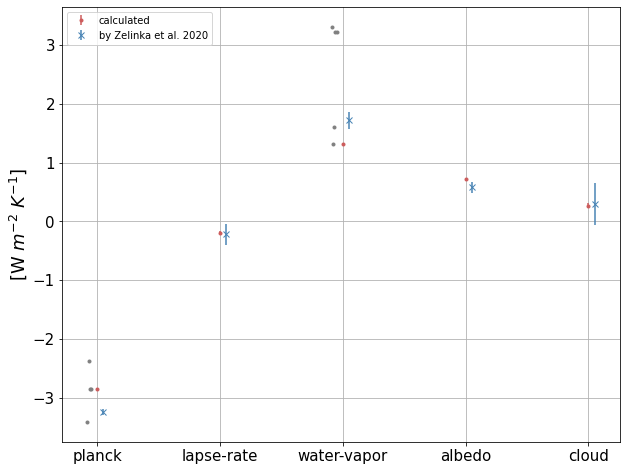

In [22]:
#grafico feedback
ac = (fb_coef[('cld', 'planck-surf')].slope + fb_coef[('cld', 'planck-atmo')].slope)
data = [ac, fb_coef[('cld','lapse-rate')].slope, fb_coef[('cld', 'water-vapor')].slope, fb_coef[('cld', 'albedo')].slope, fb_cloud2]

data1 =[-3.24, -0.22,  1.72,  0.58, 0.29]
err = [(fb_coef[('cld', 'planck-surf')].stderr + fb_coef[('cld', 'planck-atmo')].stderr), fb_coef[('cld','lapse-rate')].stderr, fb_coef[('cld', 'water-vapor')].stderr, fb_coef[('cld', 'albedo')].stderr, fb_cloud_err2]

err1 = [0.05, 0.18, 0.14, 0.09, 0.36]
fbnams1 = ['planck', 'lapse-rate', 'water-vapor', 'albedo', 'cloud']

fig = plt.figure(figsize=(10,8))
offset=0.05
plt.errorbar(range(len(fbnams1)), data, yerr=err, marker=".", linestyle= 'None', label='calculated', color='indianred')
plt.errorbar([x+offset for x in range(len(fbnams1))], data1, yerr=err1, marker="x", linestyle= 'None', label='by Zelinka et al. 2020', color='steelblue')

tip = 'cld'
for mtd in range(5):
    if (tip, 'planck-atmo', f'method{mtd}') in fb_coef:
        plt.scatter(0 - 0.05 - 0.01*mtd, fb_coef[(tip, 'planck-surf')].slope + fb_coef[(tip, 'planck-atmo', f'method{mtd}')].slope, color = 'grey', marker = '.')

for mtd in range(6):
    if (tip, 'water-vapor', f'method{mtd}') in fb_coef:
        plt.scatter(2 - 0.05 - 0.01*mtd, fb_coef[(tip, 'water-vapor', f'method{mtd}')].slope, color = 'grey', marker = '.')

plt.xticks(range(len(fbnams1)), fbnams1)
plt.legend(loc='upper left')
plt.ylabel('[W $m^{-2}$ $K^{-1}$]')
#plt.title('Climate Feedback')
plt.grid()
fig.savefig(cart_out + 'check_feedbacks_vs_zelinka.pdf')

### 1 year regression

In [23]:
n_aver = 1

In [26]:
fbnams = ['planck-surf',  'water-vapor',  'albedo', 'lapse-rate', 'planck-atmo']

fb_coef_1yr = dict()
for ke in feedbacks:
    res = stats.linregress(gtas, feedbacks[ke])
    fb_coef_1yr[ke] = res

pickle.dump(fb_coef, open(cart_out + 'fbcoef_150y_control_1yrregre.p', 'wb'))

In [27]:
### CLOUD FEEDBACK shell 2008
fbnams = ['planck-surf',  'water-vapor',  'albedo', 'lapse-rate', 'planck-atmo']

N0 = net_toa_cs
N = net_toa

crf = (N0 - N) 
crf = crf.groupby('time.year').mean('time')

N = N.groupby('time.year').mean()
N0 = N0.groupby('time.year').mean()

crf_glob = ctl.global_mean(crf).compute()
N_glob = ctl.global_mean(N).compute()
N0_glob = ctl.global_mean(N0).compute()

res_N = stats.linregress(gtas, N_glob)
res_N0 = stats.linregress(gtas, N0_glob)
res_crf = stats.linregress(gtas, crf_glob)

# Only first 10 years for estimating forcing
n_forc = 10
F0 = stats.linregress(gtas[:n_forc], N0_glob[:n_forc]).intercept - pivar_nettoa_glob_cs
F = stats.linregress(gtas[:n_forc], N_glob[:n_forc]).intercept - pivar_nettoa_glob

# F0 = res_N0.intercept - pivar_nettoa_glob_cs # pimean[('rlutcs')] + pimean[('rsutcs')] 
# F = res_N.intercept - pivar_nettoa_glob # pimean[('rlut')] + pimean[('rsut')]

print(F0, F)

# fb_cloud = res_crf.slope + np.nansum([fb_coef[(exp, 'clr', fbn)].slope - fb_coef[(exp, 'cld', fbn)].slope for fbn in fbnams]) + (F0_glob - F_glob)/gtas[-5:].mean() ## as in Soden
fb_cloud2 = -res_crf.slope + np.nansum([fb_coef_1yr[('clr', fbn)].slope - fb_coef_1yr[('cld', fbn)].slope for fbn in fbnams]) #letto in Caldwell2016

fb_cloud_err2 = np.sqrt(res_crf.stderr**2 + np.nansum([fb_coef_1yr[('cld', fbn)].stderr**2 for fbn in fbnams]))

#pickle.dump(fb_cloud2, open(cart_out + 'prima fase/cloud_feedback.p', 'wb'))
#pickle.dump(fb_cloud_err2, open(cart_out + 'prima fase/clouderr_feedback.p', 'wb'))


<xarray.DataArray ()>
array(8.35222252) <xarray.DataArray ()>
array(7.78453929)


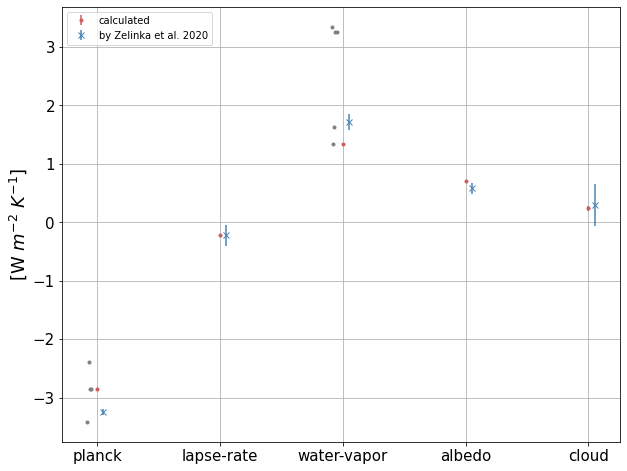

In [29]:
#grafico feedback
ac = (fb_coef_1yr[('cld', 'planck-surf')].slope + fb_coef_1yr[('cld', 'planck-atmo')].slope)
data = [ac, fb_coef_1yr[('cld','lapse-rate')].slope, fb_coef_1yr[('cld', 'water-vapor')].slope, fb_coef[('cld', 'albedo')].slope, fb_cloud2]

data1 =[-3.24, -0.22,  1.72,  0.58, 0.29]
err = [(fb_coef_1yr[('cld', 'planck-surf')].stderr + fb_coef_1yr[('cld', 'planck-atmo')].stderr), fb_coef[('cld','lapse-rate')].stderr, fb_coef_1yr[('cld', 'water-vapor')].stderr, fb_coef_1yr[('cld', 'albedo')].stderr, fb_cloud_err2]

err1 = [0.05, 0.18, 0.14, 0.09, 0.36]
fbnams1 = ['planck', 'lapse-rate', 'water-vapor', 'albedo', 'cloud']

fig = plt.figure(figsize=(10,8))
offset=0.05
plt.errorbar(range(len(fbnams1)), data, yerr=err, marker=".", linestyle= 'None', label='calculated', color='indianred')
plt.errorbar([x+offset for x in range(len(fbnams1))], data1, yerr=err1, marker="x", linestyle= 'None', label='by Zelinka et al. 2020', color='steelblue')

tip = 'cld'
for mtd in range(5):
    if (tip, 'planck-atmo', f'method{mtd}') in fb_coef_1yr:
        plt.scatter(0 - 0.05 - 0.01*mtd, fb_coef_1yr[(tip, 'planck-surf')].slope + fb_coef_1yr[(tip, 'planck-atmo', f'method{mtd}')].slope, color = 'grey', marker = '.')

for mtd in range(6):
    if (tip, 'water-vapor', f'method{mtd}') in fb_coef_1yr:
        plt.scatter(2 - 0.05 - 0.01*mtd, fb_coef_1yr[(tip, 'water-vapor', f'method{mtd}')].slope, color = 'grey', marker = '.')

plt.xticks(range(len(fbnams1)), fbnams1)
plt.legend(loc='upper left')
plt.ylabel('[W $m^{-2}$ $K^{-1}$]')
#plt.title('Climate Feedback')
plt.grid()
fig.savefig(cart_out + 'check_feedbacks_vs_zelinka_1yr.pdf')